# Example showing how mix python and madagascar processing #
## Notebook creates synthetic for TLE "Edge-preserving smoothing ... by Yi Luo et. al. ##
Reproduced by Luke Decker and Karl Schleicher

In [1]:
# basic imports.  
import os
import numpy as np
import m8r

backend='nbagg' # Use the 'nbagg' backend to render and you can zoom and pan plots.  
backend='inline' # 
if backend=='nbagg':
    import matplotlib
    matplotlib.use('nbagg') # Use the 'nbagg' backend
else:
    # magic command to render inline
    %matplotlib inline 
    
#import matplotlib.pyplot must be after matplotlib.use('nbagg') 
import matplotlib.pyplot as plt 

In [2]:
#create a numpy ndarray (a 2D array) of all floating point zeros
a = np.zeros((61,72),dtype='float32') 
# Make a section with two faulsted horizons.  Sample rate is 4 ms.
# Data will be high cut filterred at 62.5 hz.
# Make two horizons. fault at center has throw of two samples.
# On left side of section horizons are at samples 24 and 28.
# On right side of section horizons are at samples 22 and 46.
a[0:30,24]=1.0
a[30:61,20]=1.0
a[0:30,48]=1.0
a[30:61,44]=1.0

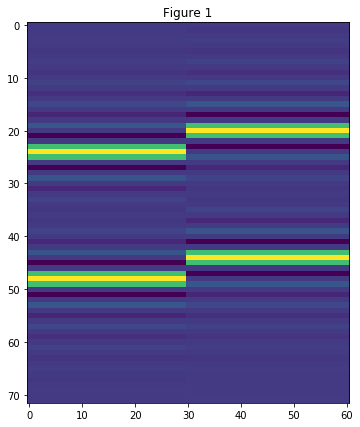

In [3]:
# use high cut filter to ideal model to create synthetic seismic for Figure 1
deltat=.004
itrace=0
trace=a[0]
frequencies=np.fft.rfftfreq(trace.size,d=deltat)

# apply high cut filter using numpy library
ramp_freq=np.array([.0,55.,70.,125.])
ramp_amp =np.array([1.0,1.0, .0,.0])
ramp=np.square(np.cos(np.pi/2.0*(1.0-np.interp(frequencies,ramp_freq,ramp_amp))))
#fig, ax = plt.subplots(figsize=(15, 2))
#plt.plot(frequencies,ramp)
#plt.show()

a_filterred = np.zeros((61,72),dtype='float32') 
for itrace in range(a.shape[0]):
    trace=a[itrace]
    TRACE=np.fft.rfft(trace)
    TRACE_FILTERRED=ramp*TRACE
    trace_filterred=np.fft.irfft(TRACE_FILTERRED)
    a_filterred[itrace,:]=2.0*trace_filterred # multiple by 2 to make peak of wavelet 1.0 instaed of .5

#ax.set_xlabel('Time in Seconds')
#ax.set_ylabel('Amplitude')
fig = plt.figure(figsize=(7,7))
plt.title('Figure 1')
plt.imshow(a_filterred.T)
plt.show()

In [4]:
# define function for mean smoothing, works on 1D arrays, nfilt is smoothing radius
# number of points in filter is 2*nfilt+1
def mean_smooth(array,nfilt):
    # determine array size
    n = array.shape[0]
    # decleare mean array
    mean = np.zeros(n,dtype='float32')
    for i in range(n):
        # create temporary array with date, making sure to not go out of bounds
        temp = array[max(0,i-nfilt):min(n-1,i+nfilt)]
        # determine the average
        mean[i] = np.average(temp)
    return mean;

In [5]:
# define function for edge preserving smoothing, works on 1D arrays, nfilt is smoothing radius
# number of points in filter is 2*nfilt+1
def edge_smooth(array,nfilt,):
    # determine array size
    n = array.shape[0]
    # decleare output array, using float32 for Madagascar compatibility
    edge = np.zeros(n,dtype='float32')
    # declare variance array
    var  = np.zeros(n,dtype='float32')
    # declare array for storing mean
    mean = np.zeros(n,dtype='float32')
    # loop through data
    for i in range(n):
        # generate temporary array to hold local window
        temp = array[max(0,i-nfilt):min(n,i+nfilt)]
        # calculate variance
        var[i] = np.var(temp)
        # and the mean
        mean[i] = np.average(temp)
    # now we loop through again, selecting the minimum variance window
    for i in range(n):
        edge[i] = mean[ np.argmin(var[max(0,i-nfilt):min(n,i+nfilt)]) + i - nfilt - min(0,i-nfilt) ]
    return edge;

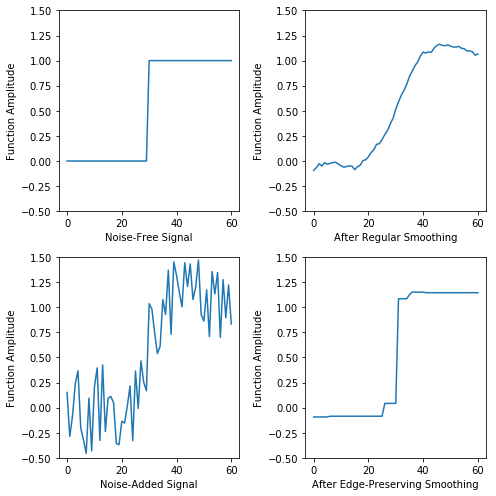

In [6]:
# now we recreate figure 2
fig = plt.figure(figsize=(7,7))

ax1 = plt.subplot2grid((2,2), (0,0),)
ax2 = plt.subplot2grid((2,2), (1,0),)
ax3 = plt.subplot2grid((2,2), (0,1),)
ax4 = plt.subplot2grid((2,2), (1,1),)
# figure 2a
ax1.plot(a_filterred[:,20])
ax1.set_xlabel("Noise-Free Signal")
ax1.set_ylim([-0.5, 1.5])
ax1.set_ylabel("Function Amplitude")
# figure 2b
a_noise=a_filterred+(np.random.rand(a.shape[0],a.shape[1])-.5)
ax2.plot(a_noise[:,20])
ax2.set_xlabel("Noise-Added Signal")
ax2.set_ylim([-0.5, 1.5])
ax2.set_ylabel("Function Amplitude")
# figure 2c
a_mean = mean_smooth(a_noise[:,20],10)
ax3.plot(a_mean)
ax3.set_xlabel("After Regular Smoothing")
ax3.set_ylim([-0.5, 1.5])
ax3.set_ylabel("Function Amplitude")
# figure 2d
a_edge = edge_smooth(a_noise[:,20],10)
ax4.plot(a_edge)
ax4.set_xlabel("After Edge-Preserving Smoothing")
ax4.set_ylim([-0.5, 1.5])
ax4.set_ylabel("Function Amplitude")
# ensure that labels don't overlap figures
plt.tight_layout()
plt.rcParams["figure.figsize"] = 3,3
plt.show()



now that we have played around with the 1 dimensional reproduction and gotten our hands a little bit dirty, we may move onto 2 dimensions!

In [7]:
# lets define a function that creates checkerboards for us
# creates checkerboards on n2 x n1 grid, with square length d2 x d1, initial offsets o2, o1.
def checkerboard(n2,n1,d2,d1,o2,o1):
    # initialize array
    board = np.zeros((n2,n1),dtype='float32')
    # loop through
    for j in range(n2):
        y = (j-o2)/d2+1
        for i in range(n1):
            x = (i-o1)/d1+1
            xy = x+y
            # why does this work?  why doesn't this always return 0?
            board[j,i]=(xy-xy/2-xy/2)
    return board;

In [8]:
# define function for mean smoothing
def mean_smooth_2d(array,nfilt2,nfilt1,flag=1):
    # flag is a parameter related to the smoothing stencil.  
    # flag=1 corresponds to cell centered, odd number stencils.  
    # flag=0 corresponds to skewed, even number stencils.  This was added so
    # we may properly reproduce the checkerboard figure, which appears to have
    # been completed using a 4x4 skew stencil
    # determine array dimensions, python is (n2,n1)
    n2 = np.shape(array)[0]
    n1 = np.shape(array)[1]
    # initialize the output array
    mean = np.zeros(np.shape(array),dtype='float32')
    # loop through elements
    for j in range(n2):
        for i in range(n1):
            # window out the local array
            temp = array[max(0,j-nfilt2):min(n2-1,j+nfilt2+flag),max(0,i-nfilt1):min(n1-1,i+nfilt1+flag)]
            # calculate mean
            mean[j,i] = np.average(temp)
    return mean;

In [9]:
# define function for edge preserving smoothing
# how is this different than the 1d case in terms of implementation and how dimensions are dealt with?
def edge_smooth_2d(array,nfilt2,nfilt1, flag=1):
    # flag is a parameter related to the smoothing stencil.  
    # flag=1 corresponds to cell centered, odd number stencils.  
    # flag=0 corresponds to skewed, even number stencils.  This was added so
    # we may properly reproduce the checkerboard figure, which appears to have
    # been completed using a 4x4 skew stencil
    # get dimensions
    n2 = np.shape(array)[0]
    n1 = np.shape(array)[1]
    # array for holding variances
    var = np.zeros(np.shape(array),dtype='float32')
    # array for holding means
    mean = np.zeros(np.shape(array),dtype='float32')
    # loop through indxes and calculate variance for each window
    for j in range(n2):
        for i in range(n1):
            # window out the local array
            temp = array[max(0,j-nfilt2):min(n2-1,j+nfilt2+flag),max(0,i-nfilt1):min(n1-1,i+nfilt1+flag)]
            # calculate variance
            var[j,i] = np.var(temp)
            # calculate mean
            mean[j,i] = np.mean(temp)
    # now we again loop through indexes to determine which window within the
    # acceptable range of each index has the lowest variance
    edge = np.zeros(np.shape(array),dtype='float32')
    for j in range(n2):
        for i in range(n1): 
            temp = var[max(0,j-nfilt2):min(n2-1,j+nfilt2+flag),max(0,i-nfilt1):min(n1-1,i+nfilt1+flag)]
            # determine index with minimal variance
            mindex = np.unravel_index(temp.argmin(), np.shape(temp))
            # transform this local index into an index in the global array
            w1 = mindex[1] - nfilt1 + max(0,nfilt1-i) + i
            w2 = mindex[0] - nfilt2 + max(0,nfilt2-j) + j
            # write mean of this variance-minimizing window to array
            edge[j,i] = mean[w2,w1]
    return edge;

Here we attempt to recreate the checkerboard figure using a cell centered 5x5 stencil.
However, with the 4x4 checkerboards this doesn't lead to the results we want!
Please see below.

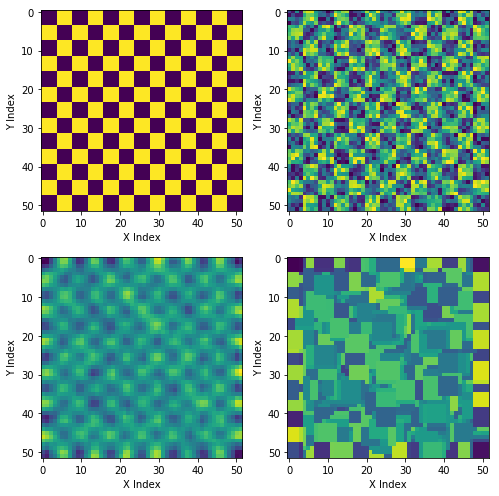

In [10]:
# lets generate the checkerboard for figure 3a using the program we just wrote
board = checkerboard(52,52,4,4,0,0)
# we add noise to the checkerboard for figure 3b
board_noise = board + (np.random.rand(board.shape[0],board.shape[1])-.5)
# and then do 5x5 mean value smoothing (2x2 smoothing radius) for figure 3c
board_mean = mean_smooth_2d(board_noise,2,2)
# as well as 5x5 edge-preserving smoothing (2x2 smoothing radius) for figure 3d
board_edge = edge_smooth_2d(board_noise,2,2)

# and plot the results to generate Figure 3
fig = plt.figure(figsize=(7,7))

ax1 = plt.subplot2grid((2,2), (0,0),)
ax2 = plt.subplot2grid((2,2), (0,1),)
ax3 = plt.subplot2grid((2,2), (1,0),)
ax4 = plt.subplot2grid((2,2), (1,1),)

# figure 3a
ax1.imshow(board)
ax1.set_xlabel("X Index")
ax1.set_ylabel("Y Index")
# figure 3b
ax2.imshow(board_noise)
ax2.set_xlabel("X Index")
ax2.set_ylabel("Y Index")
# figure 3c
ax3.imshow(board_mean)
ax3.set_xlabel("X Index")
ax3.set_ylabel("Y Index")
# figure 3d
ax4.imshow(board_edge)
ax4.set_xlabel("X Index")
ax4.set_ylabel("Y Index")

# ensure that labels don't overlap figures
plt.tight_layout()
plt.show()

So now we recreate the experiment using skewed 4x4 stencils.  
This corresponds to setting flag=0 in the function calls.

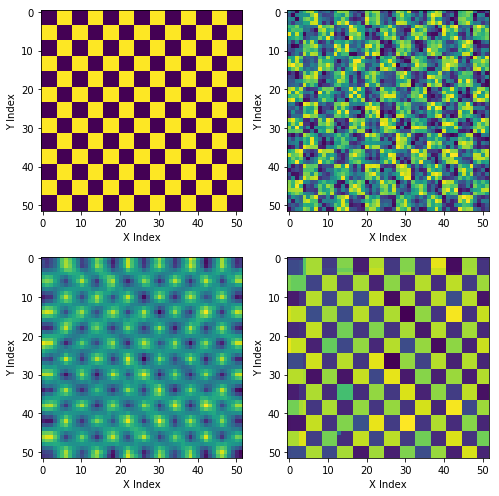

In [11]:
# but these dont look right!  so we adjust our programs using the "flag" variable to only use a 4x4 stencil
# lets generate the checkerboard for figure 3a using the program we just wrote
board = checkerboard(52,52,4,4,0,0)
# we add noise to the checkerboard for figure 3b
board_noise = board + (np.random.rand(board.shape[0],board.shape[1])-.5)
# and then do 5x5 mean value smoothing (2x2 smoothing radius) for figure 3c
board_mean = mean_smooth_2d(board_noise,2,2,0)
# as well as 5x5 edge-preserving smoothing (2x2 smoothing radius) for figure 3d
board_edge = edge_smooth_2d(board_noise,2,2,0)

# and plot the results to generate Figure 3
fig = plt.figure(figsize=(7,7))

ax1 = plt.subplot2grid((2,2), (0,0),)
ax2 = plt.subplot2grid((2,2), (0,1),)
ax3 = plt.subplot2grid((2,2), (1,0),)
ax4 = plt.subplot2grid((2,2), (1,1),)

# figure 3a
ax1.imshow(board)
ax1.set_xlabel("X Index")
ax1.set_ylabel("Y Index")
# figure 3b
ax2.imshow(board_noise)
ax2.set_xlabel("X Index")
ax2.set_ylabel("Y Index")
# figure 3c
ax3.imshow(board_mean)
ax3.set_xlabel("X Index")
ax3.set_ylabel("Y Index")
# figure 3d
ax4.imshow(board_edge)
ax4.set_xlabel("X Index")
ax4.set_ylabel("Y Index")

# ensure that labels don't overlap figures
plt.tight_layout()
plt.show()

In [12]:
# this program applies the laplace filter to elements within a 2d array
def laplacian(array, dx=1, dz=1):
    # laplacian stencil constants    
    c0 = -30./12.
    c1 = +16./12. 
    c2 = - 1./12.
    # initialize output array
    laplace = np.zeros(np.shape(array),dtype='float32')
    # perform vectored laplacian calculation
    laplace[2:-2,2:-2]    = \
    c0* array[2:-2,2:-2]  * (dx + dz)         + \
    c1*(array[2:-2,1:-3]  + array[2:-2,3:-1])*dx + \
    c2*(array[2:-2, :-4]  + array[2:-2,4:  ])*dx + \
    c1*(array[1:-3,2:-2]  + array[3:-1,2:-2])*dz + \
    c2*(array[ :-4,2:-2]  + array[4:  ,2:-2])*dz
    return laplace;
    

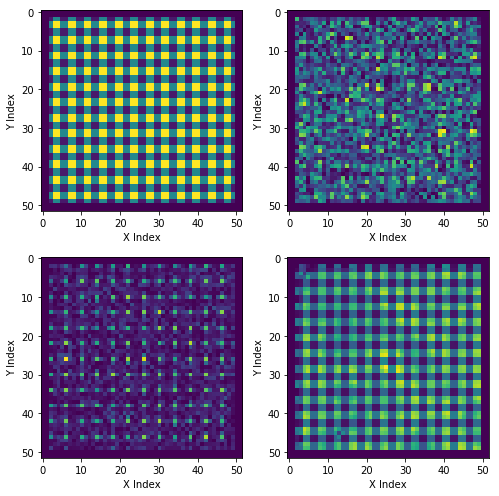

In [13]:
# and plot the outputs of edge detection on our checkerboard 
# for edge detection we use the absolute value of the laplacian
# initialize multiplot
fig = plt.figure(figsize=(7,7))
ax1 = plt.subplot2grid((2,2), (0,0),)
ax2 = plt.subplot2grid((2,2), (0,1),)
ax3 = plt.subplot2grid((2,2), (1,0),)
ax4 = plt.subplot2grid((2,2), (1,1),)
# figure #a
ax1.imshow(np.abs(laplacian(board)))
ax1.set_xlabel("X Index")
ax1.set_ylabel("Y Index")
# figure #b
ax2.imshow(np.abs(laplacian(board_noise)))
ax2.set_xlabel("X Index")
ax2.set_ylabel("Y Index")
# figure #c
ax3.imshow(np.abs(laplacian(board_mean)))
ax3.set_xlabel("X Index")
ax3.set_ylabel("Y Index")
# figure #d
ax4.imshow(np.abs(laplacian(board_edge)))
ax4.set_xlabel("X Index")
ax4.set_ylabel("Y Index")
# ensure that labels don't overlap figures
plt.tight_layout()
plt.show()

In [14]:
# define function for field data
# sr1, sr2 are edge preserving smoothing radii in dim1 and dim2
# get libraries to fetch data from internet.  Try to import 
#python3 libraries. If that gets error, you must be running python2,
# so import those libraries
try:
    # python3
    import urllib.request as urllib
except:
    #python2
    import urllib as urllib

def read_edge(name,sr1,sr2,n1,n2,pclip=99,d1=1,d2=1,o1=0,o2=0):
    # remove file if it is already here
    os.system('rm %s.dat'%name)
    # pull file
    urllib.urlretrieve('https://s3.amazonaws.com/open.source.geoscience/repro-zoo-2018/luo-zoo-2002/%s.dat'%name,
                       '%s.dat'%name)
                       
    os.system('''echo n1=%i n2=%i d1=%g d2=%g o1=%g o2=%g data_format="native_float" esize=4 in=%s.dat > %s.rsf'''%(n1,n2,d1,d2,o1,o2,name,name))

    fil = m8r.Input(name+'.rsf')
    # read file
    filread = fil.read()
    # convert fully to np array
    array = filread.byteswap()
    # initialize plots

    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((2,2), (0,0),)
    ax2 = plt.subplot2grid((2,2), (0,1),)
    ax3 = plt.subplot2grid((2,2), (1,0),)
    ax4 = plt.subplot2grid((2,2), (1,1),)
    # input data
    ax1.imshow(array)
    ax1.set_title("Input Time Slice")
    # perform edge preserving smoothing
    edgep = edge_smooth_2d(array,sr1,sr2)
    ax2.imshow(array)
    ax2.set_title("EPS Time Slice")
    edgelst = [array,edgep]
    titlelst = ['Input','EPS']
    axlst = [ax3,ax4]
    for i in range(len(edgelst)):
        # edge detection
        ed = np.abs(laplacian(edgelst[i]))
        # plot with percentile clip
        axlst[i].imshow(np.clip(ed,0,np.percentile(ed,pclip)))
        axlst[i].set_title(titlelst[i]+" Edge Detection")
    # perform edge detection, plot
    plt.tight_layout()
    plt.show()

We conduct the edge preserving smoothing and edge detection experiment on field data

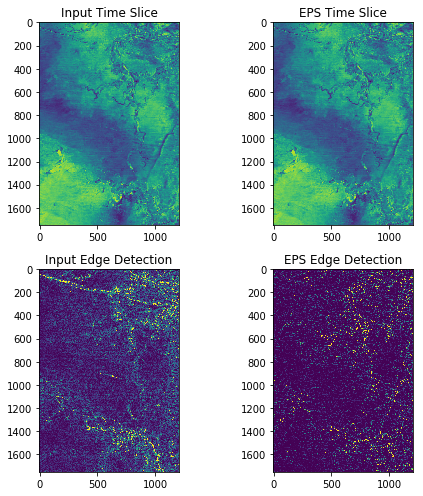

In [15]:
# perform on parihaka time slices
# first gx 130
read_edge('gx130',5,5,1200,1750)

And on a second slice

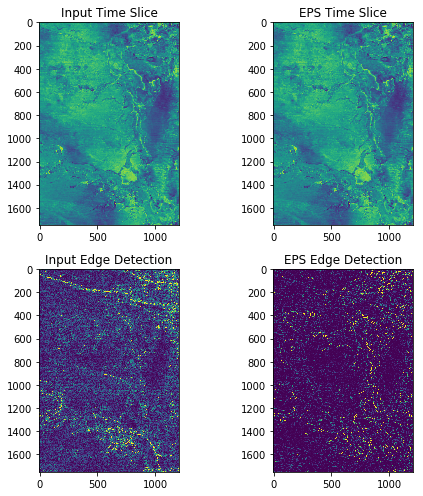

In [16]:
# now on gx122
read_edge('gx122',5,5,1200,1750)